In [1]:
import requests
import pandas as pd
import csv
import os
import sys
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from tqdm import tqdm

#Set Seaborn Styles
sns.set_style("darkgrid")
sns.set(font_scale=1.75)
 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Change directory to project root directory
os.chdir("..")

#Import custom code
from src.code_flow.CreateJupyterNotebookHeadings import jupyternotebookheadings1, jupyternotebookheadings2

In [2]:
df=pd.read_csv('data/interim/post_eda_diabetes_ACS_populous_counties_2006to2017.csv',index_col=0)

In [3]:
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression

**Drop unneeded columns, encode cateogrical variables.**

In [4]:
#Combine state & county fips
df.state_fips=df.state_fips.astype('int')
df.county_fips=df.county_fips.astype('int')
df['state_county_fips']=df.state_fips.astype('str')+' '+df.county_fips.astype('str')
#Save a dataframe with just state/county names and fips
df_names=df[['state','county','state_fips','county_fips','state_county_fips']]
#Drop columns not to be included in the model 
col=['state','county','state_fips','county_fips','diabetes_%_lower', 'diabetes_%_upper','male']
df.drop(columns=col,inplace=True)
#Encode Region variable
df=pd.get_dummies(df,drop_first=True,columns=['region'])
#Check variables types
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11296 entries, 12 to 40269
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_pop           11296 non-null  float64
 1   female              11296 non-null  float64
 2   white_pop           11296 non-null  float64
 3   black_pop           11296 non-null  float64
 4   amer_indian_pop     11296 non-null  float64
 5   pacific_island_pop  11296 non-null  float64
 6   asian_pop           11296 non-null  float64
 7   hispanic_pop        11296 non-null  float64
 8   other_pop           11296 non-null  float64
 9   20_24_years         11296 non-null  float64
 10  25_34_years         11296 non-null  float64
 11  35_44_years         11296 non-null  float64
 12  45_54_years         11296 non-null  float64
 13  55_64_years         11296 non-null  float64
 14  65_74_years         11296 non-null  float64
 15  75_84_years         11296 non-null  float64
 16  85_

In [5]:
df.head()

,total_pop,female,white_pop,black_pop,amer_indian_pop,pacific_island_pop,asian_pop,hispanic_pop,other_pop,20_24_years,25_34_years,35_44_years,45_54_years,55_64_years,65_74_years,75_84_years,85_plus_years,median_income,education_bach,education_hs,diabetes_%,state_county_fips,years_since_2006,region_Northeast,region_South,region_West
12,169162.0,50.75,87.63,10.15,1.16,0.0,0.56,2.47,1.97,6.65,13.20,13.94,14.19,11.71,8.35,6.28,1.32,44878.0,25.8,86.7,7.8,1 3,0.0,0,1,0
13,171769.0,51.00,87.43,10.48,0.92,0.0,0.35,2.69,1.46,5.56,13.37,13.40,14.03,11.31,8.51,6.09,1.81,49119.0,26.4,88.3,8.1,1 3,1.0,0,1,0
14,174439.0,50.72,87.42,10.08,1.78,0.0,0.90,2.88,1.51,4.95,14.46,13.43,13.49,11.35,8.61,6.29,1.62,52320.0,29.5,87.9,8.6,1 3,2.0,0,1,0
15,179878.0,51.15,86.89,10.19,0.97,0.0,0.82,3.31,1.98,5.37,12.61,12.88,14.33,12.52,9.66,5.37,2.04,48487.0,26.5,89.2,9.9,1 3,3.0,0,1,0
16,183195.0,50.91,88.50,9.86,1.29,0.0,0.95,4.41,0.99,4.60,11.77,12.89,14.89,13.57,9.99,5.01,1.73,47502.0,27.2,87.7,10.2,1 3,4.0,0,1,0


In [6]:
df_test=df[['state_county_fips','years_since_2006','diabetes_%']]
df_test['one_year_past']=df['years_since_2006']+1
df_test['two_years_past']=df['years_since_2006']+2
df_test=df_test.drop(columns=['years_since_2006']).rename(columns={'diabetes_%':'diabetes_past'})

<ipython-input-6-69c102cee3ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['one_year_past']=df['years_since_2006']+1
<ipython-input-6-69c102cee3ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['two_years_past']=df['years_since_2006']+2


In [7]:
a=['two_years_past']
b=['one_year_past']
df=df.merge(df_test.drop(columns=a),how='left',left_on=['years_since_2006','state_county_fips'],
            right_on=['one_year_past','state_county_fips']).drop(
            columns=['one_year_past']).rename(columns={'diabetes_past':'diabetes_1_year_past'})
df=df.merge(df_test.drop(columns=b),how='left',left_on=['years_since_2006','state_county_fips'],
            right_on=['two_years_past','state_county_fips']).drop(
            columns=['two_years_past']).rename(columns={'diabetes_past':'diabetes_2_years_past'})

**Inspect distributions.**

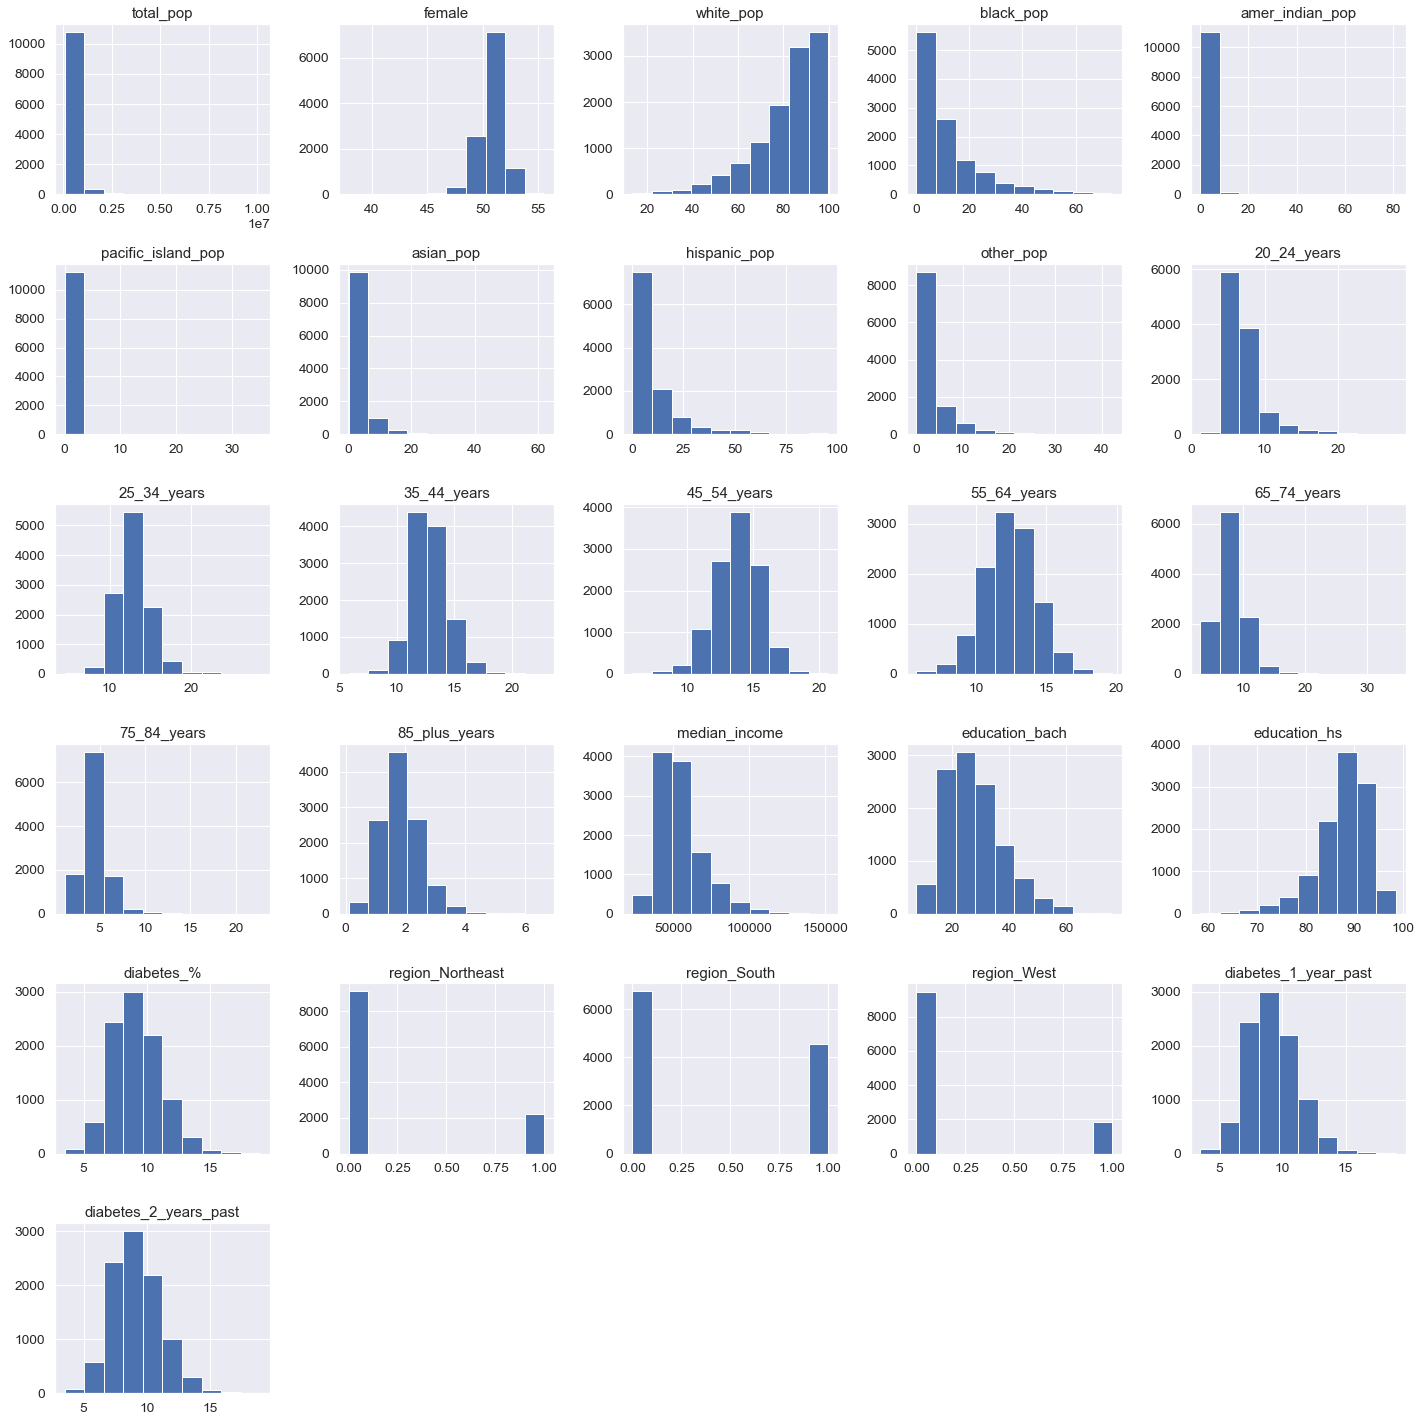

In [8]:
sns.set(font_scale=1.25)
col=['years_since_2006']
df.drop(columns=col).hist(figsize=(20,20))
plt.tight_layout()
plt.show()

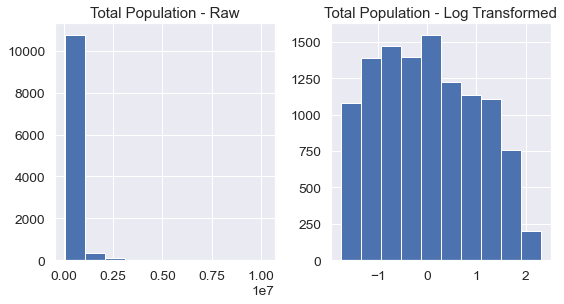

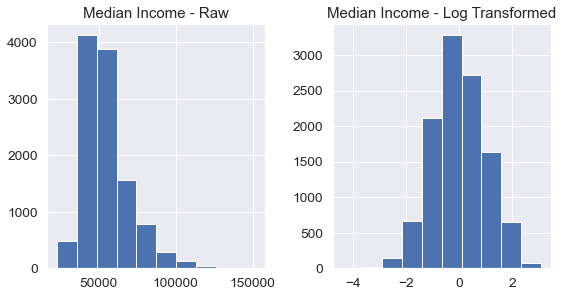

In [9]:
pt=PowerTransformer(method='box-cox')
q=np.array(df.total_pop).reshape(-1,1)
w=pt.fit_transform(q)

plt.subplots(figsize=(8,8))
plt.subplot(2,2,1)
plt.hist(q)
plt.title('Total Population - Raw')
plt.subplot(2,2,2)
plt.hist(w)
plt.title('Total Population - Log Transformed')
plt.tight_layout()

pt=PowerTransformer(method='box-cox')
q=np.array(df.median_income).reshape(-1,1)
w=pt.fit_transform(q)

plt.subplots(figsize=(8,8))
plt.subplot(2,2,3)
plt.hist(q)
plt.title('Median Income - Raw')
plt.subplot(2,2,4)
plt.hist(w)
plt.title('Median Income - Log Transformed')
plt.tight_layout()

plt.show()

**Split into test/train sets**

In [10]:
df.years_since_2006.describe()

count    11296.000000
mean         6.498938
std          4.030868
min          0.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         13.000000
Name: years_since_2006, dtype: float64

In [11]:
# CHANGE THIS
df=df[df.years_since_2006>1]
df_2006_2016=df[df.years_since_2006<11].reset_index(drop=True)
df_2017=df[df.years_since_2006==11].reset_index(drop=True)
df_2018_2019=df[df.years_since_2006>11].reset_index(drop=True).drop(columns=['diabetes_%'])

In [12]:
def log_transform(variable):
    pt=PowerTransformer(method='box-cox')
    q=np.array(df_2006_2016[variable]).reshape(-1,1)
    w=pt.fit_transform(q)
    df_2006_2016.loc[:,variable]=w
    df_2017.loc[:,variable]=pt.transform(np.array(df_2017[variable]).reshape(-1,1))
    df_2018_2019.loc[:,variable]=pt.transform(np.array(df_2018_2019[variable]).reshape(-1,1))

In [13]:
log_transform('total_pop')
log_transform('median_income')

In [14]:
def MAE(df):
    return(np.mean(np.abs(df.diabetes_pred-df.diabetes_actual_2017)))

In [15]:
#Deterime mean absolute difference between predicting 2016's value for 2017
df_pred=df_2006_2016[df_2006_2016.years_since_2006==10][['state_county_fips','diabetes_%']].rename(columns={'diabetes_%':'diabetes_pred'})
df_actual=df_2017[['state_county_fips','diabetes_%']].rename(columns={'diabetes_%':'diabetes_actual_2017'})
df_pred_actual=df_pred.merge(df_actual,how='inner',right_on='state_county_fips',left_on='state_county_fips')
MAE(df_pred_actual)

0.8745972738537794

In [16]:
df_pred_actual.head(1000)

,state_county_fips,diabetes_pred,diabetes_actual_2017
0,1 3,8.5,8.2
1,1 15,15.6,15.2
2,1 43,17.2,13.3
3,1 49,11.2,14.3
4,1 51,14.9,13.9
5,1 55,13.5,14.8
6,1 69,11.8,14.4
7,1 73,11.7,11.5
8,1 77,11.9,12.7
9,1 81,9.5,10.6


In [17]:
from sklearn.linear_model import Lasso
df_X=df_2006_2016.drop(columns=['diabetes_%'])
df_y=df_2006_2016[['diabetes_%','state_county_fips']]
county_list=list(df_X.state_county_fips.unique())

In [18]:
results={}
i=[round((0.01*j)*5,2) for j in range (1,20)]
for alpha in i:
    models_dict={}
    for county in county_list:
        X=df_X[df_X.state_county_fips==county].drop(columns=['state_county_fips'])
        y=df_y[df_y.state_county_fips==county].drop(columns=['state_county_fips'])
        clf=Lasso(alpha=alpha)
        clf.fit(X,y)
        models_dict[county]=clf

    pred_2017_dict={}
    for key, value in models_dict.items():
        df_=df_2017[df_2017.state_county_fips==key].drop(columns=['diabetes_%','state_county_fips'])
        val=float(value.predict(df_)[0])
        pred_2017_dict[key]=val

    pred_2017_df=pd.DataFrame.from_dict(pred_2017_dict,orient='index').reset_index().rename(columns={0:'diabetes_pred'})
    pred_LR=pred_2017_df.merge(df_actual,how='inner',right_on='state_county_fips',left_on='index')
    mae=MAE(pred_LR)
    results[alpha]=mae

alpha_best=min(results,key=results.get)
mae_best=results[alpha_best]
print('The best alpha value is is {} resulting in an MAE of {}'.format(alpha_best,float(mae_best)))

C:\Users\amcas\miniconda3\envs\learn_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012318004044303499, tolerance: 0.0004135555555555556
  model = cd_fast.enet_coordinate_descent(


The best alpha value is is 0.45 resulting in an MAE of 0.986455340661847


In [19]:
alpha_best=min(results,key=results.get)
mae_best=min(results)
print('The best alpha value is is {} resulting in an MAE of {}'.format(alpha_best,float(mae_best)))

The best alpha value is is 0.45 resulting in an MAE of 0.05


In [20]:
X_train=df_2006_2016.drop(columns=['diabetes_%','state_county_fips'])
y_train=df_2006_2016[['diabetes_%']]
X_test=df_2017.drop(columns=['diabetes_%','state_county_fips'])
y_test=df_2017[['diabetes_%']]

i=[1]+[1/(10**j) for j in range (1,10)]
results={}

for alpha in i:
    clf=Lasso(alpha=alpha)
    clf.fit(X_train,y_train)
    pred=clf.predict(X_test)
    df_temp=pd.DataFrame([pred,y_test['diabetes_%']]).T.rename(columns={0:'diabetes_pred',1:'diabetes_actual_2017'})
    results[alpha]=MAE(df_temp)

C:\Users\amcas\miniconda3\envs\learn_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.14701883897942, tolerance: 2.552812390196888
  model = cd_fast.enet_coordinate_descent(
C:\Users\amcas\miniconda3\envs\learn_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 616.8774394708898, tolerance: 2.552812390196888
  model = cd_fast.enet_coordinate_descent(
C:\Users\amcas\miniconda3\envs\learn_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1420.6708144195, tolerance: 2.552812390196888
  model = cd_fast.enet_coordinate_descent(
C:\Users\amcas\miniconda3\envs\learn_env\lib\site-packages\skle

In [21]:
alpha_best=min(results,key=results.get)
mae_best=results[alpha_best]
print('The best alpha value is is {} resulting in an MAE of {}'.format(alpha_best,float(mae_best)))

The best alpha value is is 0.01 resulting in an MAE of 0.8176619788185719


In [22]:
clf=Lasso(alpha=alpha_best)
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
df_temp=pd.DataFrame([pred,y_test['diabetes_%']]).T.rename(columns={0:'diabetes_pred',1:'diabetes_actual_2017'})
results[alpha]=MAE(df_temp)

In [ ]:
#Coefficient Importance
pd.DataFrame([X_train.columns,clf.coef_]).T

,0,1
0,total_pop,-0.0
1,female,0.0
2,white_pop,-0.000505
3,black_pop,0.006251
4,amer_indian_pop,0.004788
5,pacific_island_pop,-0.00017
6,asian_pop,-0.0
7,hispanic_pop,-0.007346
8,other_pop,0.0
9,20_24_years,0.0
